In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
# import datetime
# parse the ResultOrders into a table
with open('resultorders.json','r') as ordersjson:
    orders = json.load(ordersjson)

column_names = []
for v in orders["0"]:
    if not v in 'fills':
        column_names.append(v)

table = []
for k, v in orders.items():
    selected_rows = []
    for column in v:
        if column in column_names:
            selected_rows.append(v[column])
    table.append(selected_rows)

df = pd.DataFrame(table, columns=column_names)
df['ts'] = pd.to_datetime(df['ts'])

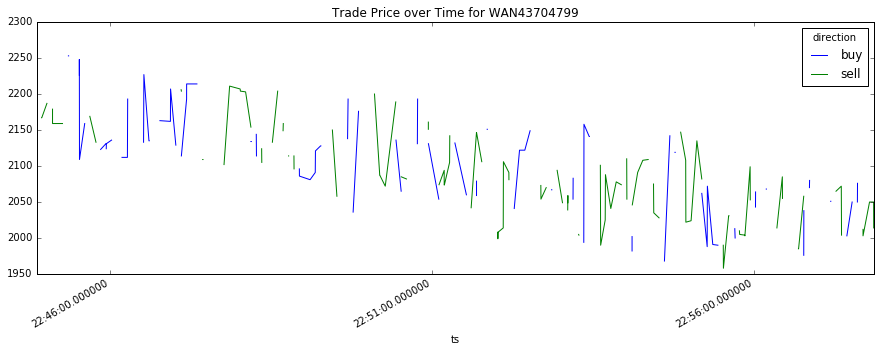

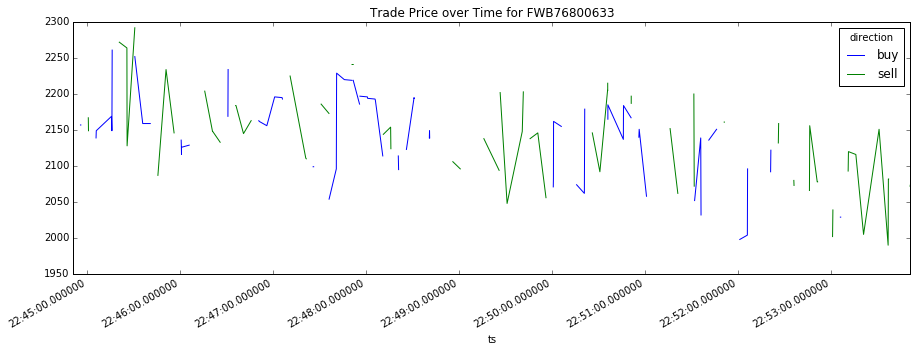

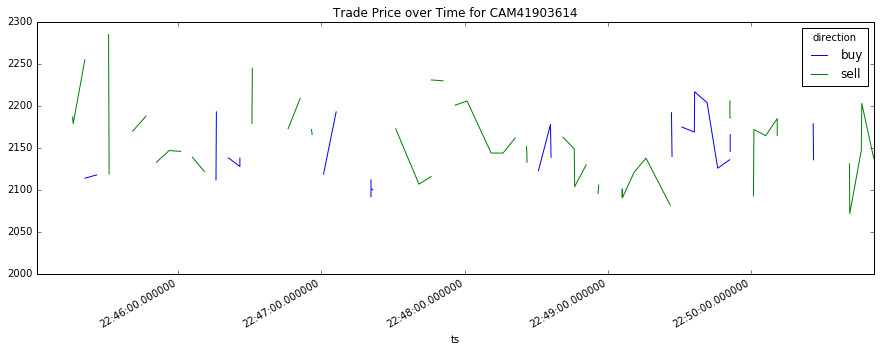

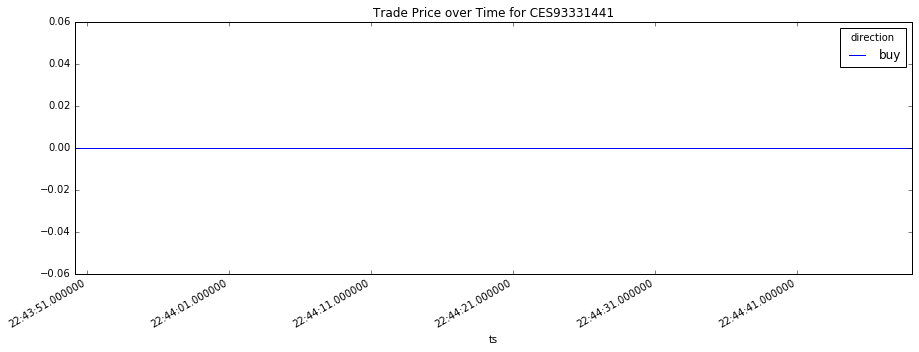

In [2]:
for account in df['account'].unique():
    acc_trades = df[df['account'] == account]
    pivoted = pd.pivot_table(acc_trades[['ts','direction','price']], 
                                 values='price', 
                                 columns='direction', index='ts')
    pivoted.plot(figsize= (15,5))
    plt.title('Trade Price over Time for %s' %(account))
plt.show()